# Generative Adversarial Networks (GANs) - An A-Z tutorial

## Table of Contents

1. Introduction
2. Background and Theory
3. Setting up the Environment
4. Dataset Introduction and Preparation
5. Implementing a Basic GAN
6. Training the GAN
7. Limitations of GANs
8. Summary and Conclusion
9. Exercises and Challenges

## <a name='introduction'>Introduction</a>

GANs are one of the most exciting advancements in machine learning in recent years. They have shown remarkable results in a variety of applications such as image synthesis, super-resolution, and image-to-image translation.

This notebook aims to introduce you to the fundamental concepts of GANs, guide you through the necessary steps to grasp the GAN framework, and provide hands-on experience with the implementation of a GAN model. By the end of this guide, you will understand:

- What GANs are and the theory behind them.
- How to implement a basic GAN model.
- How to train a GAN model.
- The limitations and challenges of GANs.

This guide is designed to be informative. It is to get you up to speed very quickly with how GANs work, not to challenge you to implement one yourself. This notebook covers the basics, but I encourage you to look at all the interesting follow-up work and see what is out there for yourself.

## 2. Background and Theory <a class='anchor' id='section2'></a>

GANs, short for Generative Adversarial Networks, are a class of machine learning frameworks introduced by [Ian Goodfellow and his colleagues in 2014](https://papers.nips.cc/paper_files/paper/2014/hash/5ca3e9b122f61f8f06494c97b1afccf3-Abstract.html). They are designed to generate new, synthetic instances of data that can pass for real, existing instances.

### 2.1 Fundamental Concepts

GANs consist of two parts:

**Generator:** This is the "counterfeiter," tasked with creating fake data. The generator takes random noise as input and generates data (e.g., an image) as output.

**Discriminator:** This is the "police," trying to distinguish the fake data from real data. It is a binary classifier that outputs the probability that the given input comes from the real dataset rather than the generator.

### 2.2 Architecture of GANs

The generator and discriminator are set up to play a two-player minimax game, in which the generator tries to fool the discriminator, and the discriminator tries to not get fooled. This process can be summarized as follows:

1. The generator creates a batch of fake data.
2. The fake data, along with real data, are given to the discriminator.
3. The discriminator classifies the data as real or fake.
4. Both the generator and discriminator learn from their mistakes and adjust for the next round.

This adversarial process leads the generator to produce increasingly realistic data, while the discriminator becomes better at distinguishing fake data. Over time, the generator can produce data that's almost indistinguishable from the real data.

### 2.3 Understanding the Loss Function

The loss function of a GAN reflects the adversarial relationship between the generator and the discriminator. The generator aims to minimize this function, while the discriminator aims to maximize it. This is the essence of the minimax game played between the two.

Mathematically, the value function $V$ for a simple GAN can be written as:

$$\min_G \max_D V(D, G) = \mathbb{E}_{x\sim p_{data}(x)}[\log D(x)] + \mathbb{E}_{z\sim p_z(z)}[\log(1-D(G(z)))]$$

where:
- `G` is the generator function, which maps from the latent space to the feature (data) space.
- `D` is the discriminator function, which outputs the probability that the data came from the real dataset.
- `z` is a random prior, a point in the latent space, which is the input that the generator uses to generate a fake sample.
- `x` is a point in the feature (data) space.

The first term in the equation is the expectation of the log-probability that the discriminator correctly classifies a real instance as real. The second term is the expectation of the log-probability that the discriminator correctly classifies a fake (generated) instance as fake.

As the generator's goal is to fool the discriminator, it tries to maximize the probability that the discriminator incorrectly classifies a fake instance as real, hence it aims to minimize `log(1 - D(G(z)))`. On the other hand, the discriminator tries to correctly classify both real and fake instances, hence it aims to maximize both `log(D(x))` and `log(1 - D(G(z)))`.

In practice, the generator minimizes the negative of this loss function, which is equivalent to maximizing the probability that the discriminator incorrectly classifies a fake instance as real.

Through this process, both the generator and the discriminator improve their ability to generate realistic data and distinguish between real and fake data, respectively.

## 3. Setting up the Environment <a class='anchor' id='section3'></a>

Now that you have a rough understanding of how GANs work, let's implement them. For the implementation, we need a couple of libraries.

In [2]:
!pip install numpy matplotlib torch torchvision tqdm

In [3]:
# Check if everything is downloaded correctly
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchvision import datasets
from tqdm import tqdm

print("Loaded all libraries successfully!")

Loaded all libraries successfully!


In [4]:
# If there is a GPU available, using it will significantly speed up the training process.
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Running on: ", DEVICE)

Running on:  cpu


## 4. Dataset Introduction and Preparation <a class='anchor' id='section4'></a>

We will be using the MNIST dataset throughout this notebook. This dataset is easily accessible through the torchvision library.

In [5]:
# Download the MNIST dataset.
mnist_dataset = datasets.MNIST(root='./.data/mnist_data/', train=True, download=True)

Dataset shape:  torch.Size([60000, 28, 28])


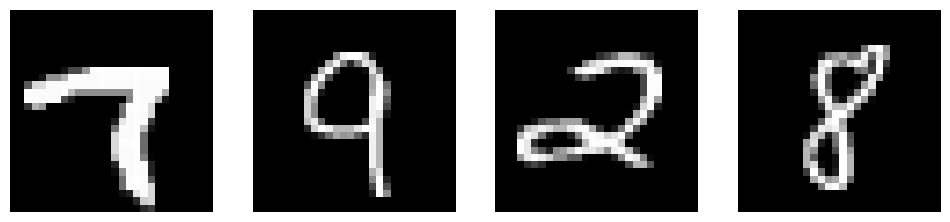

In [6]:
# The training data consists of 60.000 samples, each of 28 by 28 pixels.
print("Dataset shape: ", mnist_dataset.data.shape)

def plot_5(batch):
    indices = np.random.choice(batch.shape[0], size=4, replace=False)

    fig, axes = plt.subplots(1, 4, figsize=(12, 3))

    for i, idx in enumerate(indices):
        image = batch[idx]
        axes[i].imshow(image, cmap='gray')
        axes[i].axis('off')

    plt.show()

plot_5(mnist_dataset.data)

### 4.1 Preprocessing

Before we can use the MNIST dataset for training our GAN, we need to preprocess the images. This preprocessing involves three main steps: casting the images to floats, normalizing the images and reshaping them into 1D tensors.

**Casting:** By default, the MNIST data consists of integers. Before we can normalize the data, we need to turn the datatype into floats.

**Normalization:** The pixel intensities in the MNIST images are originally in the range of 0 to 255. We normalize these intensities to be in the range [-1, 1]. Normalization helps to stabilize the training process and makes the output of the generator easier to interpret.

**Reshaping:** Since we are going to use a simple GAN with multi-layer perceptrons, we need to flatten each image, which is originally a 2D tensor (28x28), into a 1D tensor (of size 784). This is because multi-layer perceptrons accept input data in a flat, vectorized form.

In [7]:
from torchvision.transforms import Normalize


def preprocess_dataset(dataset):
    # Casting
    dataset = dataset.float()

    # Normalization
    dataset = Normalize(0.5, 0.5)(dataset)

    # Reshaping
    dataset = dataset.reshape(dataset.shape[0], -1)

    return dataset

preprocessed_dataset = preprocess_dataset(mnist_dataset.data)
feature_dim = preprocessed_dataset.shape[-1]

print("Example of batch:")
print(preprocessed_dataset)

print("\nFeature space size:")
print(feature_dim)

Example of batch:
tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]])

Feature space size:
784


### Initializing a dataloader

Now that the data is preprocessed, it can be loaded into a dataloader for easy retrieval. To initialize a dataloader, we will need to provide a batch size. For now, lets use a batch size of $128$

In [8]:
from torch.utils.data import DataLoader

batch_size = 128
dataloader = DataLoader(dataset=preprocessed_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

## 5. Implementing a Basic GAN <a class='anchor' id='section5'></a>

Having prepared our dataset, we're now ready to implement a basic GAN. In this section, we will define the generator and discriminator networks using multi-layer perceptrons. Each network will be implemented as a separate Python class using PyTorch, a popular deep learning library.

### 5.1 Defining the Generator

The generator network takes as input a random noise vector (latent vector) and transforms it into a 1D tensor that resembles our flattened MNIST images. The generator network typically includes several fully connected layers, and we'll use the ReLU activation function for all layers except for the last one, where we'll use the Tanh function to output values in the range [-1, 1], matching our normalized MNIST images.

In [12]:
from torch import Tensor


class Generator(nn.Module):
    """
    A basic implementation for a generator network.

    This generator implementation uses a standard multi-layer perceptron (MLP).
    """

    def __init__(
            self,
            input_size: int,
            output_size: int,
            dropout: float,
            leaky_relu_slope: float,
    ):
        """
        The initialization function for the generator.

        :param input_size:          The input size of the generator.
                                        This should be equal to the size of the random prior.
        :param output_size:         The output size of the generator.
                                        This should be equal to the size of the feature space.
        :param dropout:             The dropout rate.
        :param leaky_relu_slope:    The slope of the leaky ReLU activation function.
        """
        super().__init__()

        # Initialize the sequential multi-layer perceptron model using the given parameters.
        self.sequential_model = nn.Sequential(
            nn.Linear(in_features=input_size, out_features=256),
            nn.Dropout(p=dropout, inplace=True),
            nn.LeakyReLU(negative_slope=leaky_relu_slope, inplace=True),

            nn.Linear(in_features=256, out_features=512),
            nn.Dropout(p=dropout, inplace=True),
            nn.LeakyReLU(negative_slope=leaky_relu_slope, inplace=True),

            nn.Linear(in_features=512, out_features=1024),
            nn.Dropout(p=dropout, inplace=True),
            nn.LeakyReLU(negative_slope=leaky_relu_slope, inplace=True),

            nn.Linear(in_features=1024, out_features=output_size),
            # Final Tanh activation function to force all outputs to be in the range [-1, 1]
            nn.Tanh()
        )

    def forward(self, batch: Tensor) -> Tensor:
        """
        A function that generates fake samples for a batch of priors.

        :param batch:   A batch of priors (random tensors).
        :return:        A batch of fake samples.
        """
        return self.sequential_model(batch)


prior_size = 100
dropout = 0.1
leaky_relu_slope = 0.1
generator_instance = Generator(prior_size, feature_dim, dropout, leaky_relu_slope)

### 5.2 Defining the Discriminator

The discriminator network takes as input a 1D tensor that could either be a real MNIST image or a fake image produced by the generator. It outputs a single scalar between 0 and 1, representing its confidence that the image is real. The discriminator network also typically includes several fully connected layers. We'll use the LeakyReLU activation function for these layers, and the Sigmoid function for the last layer to output a probability.

In [13]:
class Discriminator(nn.Module):
    """
    A basic implementation for a discriminator network.

    This discriminator implementation uses a standard multi-layer perceptron (MLP).
    """

    def __init__(
            self,
            input_size: int,
            dropout: float,
            leaky_relu_slope: float
    ):
        """
        The initialization function for the discriminator.

        :param input_size:              The input size of the discriminator.
                                            This should be equal to the size of the feature space.
        :param dropout:                 The dropout rate.
        :param leaky_relu_slope:        The slope of the leaky ReLU activation function.
        """
        super().__init__()

        # Initialize the sequential multi-layer perceptron model using the given parameters.
        self.sequential_model = nn.Sequential(
            nn.Linear(in_features=input_size, out_features=1024),
            nn.Dropout(p=dropout, inplace=True),
            nn.LeakyReLU(negative_slope=leaky_relu_slope, inplace=True),

            nn.Linear(in_features=1024, out_features=512),
            nn.Dropout(p=dropout, inplace=True),
            nn.LeakyReLU(negative_slope=leaky_relu_slope, inplace=True),

            nn.Linear(in_features=512, out_features=256),
            nn.Dropout(p=dropout, inplace=True),
            nn.LeakyReLU(negative_slope=leaky_relu_slope, inplace=True),

            nn.Linear(in_features=256, out_features=1)
        )

    def forward(self, batch: Tensor) -> Tensor:
        """
        A function that computes the output of the discriminator for one batch of data.

        :param batch:       The batch (2d Tensor) to compute the output for
        :return:            The output (2d Tensor)
        """
        return torch.sigmoid(self.sequential_model(batch))


discriminator_instance = Discriminator(feature_dim, dropout, leaky_relu_slope)

## 6. Training the GAN <a class='anchor' id='section6'></a>

Now that we have implemented our basic GAN, the next step is to train it. Training a GAN involves an iterative process where the generator and discriminator improve together over time.

### 6.1 Training Procedure

The training procedure for a GAN generally follows these steps:

1. **Train the Discriminator:** First, we train the discriminator by feeding it a batch of real images from the MNIST dataset and a batch of fake images generated by the generator. We calculate the loss for each and backpropagate to update the discriminator's weights.

2. **Train the Generator:** Next, we train the generator. We generate a batch of fake images and pass them through the discriminator. However, this time we calculate the loss based on how well the generator was able to "fool" the discriminator - that is, how many fake images were classified by the discriminator as real. We backpropagate this loss to update the generator's weights.

3. **Repeat:** We repeat these steps for a number of epochs, alternating between training the discriminator and the generator.

## 6.2 Training the Discriminator

The discriminator's job is to get better at distinguishing between real and fake data. During the training of the discriminator, we keep the weights of the generator constant.

Here are the steps involved:

1. **Classify Real Data:** We first pass a batch of real data from the MNIST dataset through the discriminator. We compare the output of the discriminator (probability that the data is real) to an array of ones (since the data is indeed real).

2. **Generate and Classify Fake Data:** Next, the generator creates a batch of fake data from random noise vectors. The discriminator then classifies this fake data. This time, we compare the discriminator's output to an array of zeros (since the data is fake).

3. **Compute Loss:** We compute two losses: one for the real data and one for the fake data, and we add them together. This combined loss represents the discriminator's ability to correctly classify both real and fake data.

4. **Backpropagate:** We compute the gradients and backpropagate them through the discriminator network.

5. **Update Discriminator's Weights:** Using these gradients and the learning rate, we update the discriminator's weights.

By following these steps, the discriminator learns to more accurately distinguish between real and fake data. We typically use an optimization algorithm like Adam for this step.

In [14]:
from torch.optim import Optimizer
from typing import Callable


def train_discriminator(
        generator: nn.Module,
        discriminator: nn.Module,
        batch_of_real_data: Tensor,
        discriminator_optimizer: Optimizer,
        prior_generation_function: Callable[[int, int], Tensor],
    ) -> float:
    """
    A function that trains the discriminator for one batch of data.

    :return:        The discriminator loss.
    """
    # Reset gradients of discriminator optimizer
    discriminator_optimizer.zero_grad()

    # 1. Get batch of data, and discriminate that data.
    discriminator_output_real = discriminator(batch_of_real_data)

    # 2. Generate prior, generate samples using that prior, and then discriminate the generated samples
    prior = prior_generation_function(batch_size, prior_size).to(DEVICE)
    generator_output = generator(prior)
    discriminator_output_fake = discriminator(generator_output)

    # 3. Compute total loss
    discriminator_loss = nn.BCELoss()(discriminator_output_real,
                                      torch.full_like(discriminator_output_real, 1)) + \
                         nn.BCELoss()(discriminator_output_fake,
                                      torch.full_like(discriminator_output_fake, 0))

    # 4, 5. Back propagate loss and update weights
    discriminator_loss.backward()
    discriminator_optimizer.step()

    # Return loss
    return discriminator_loss.data.item()

## 6.3 Training the Generator

The training goal of the generator is to generate data that the discriminator will incorrectly classify as real. During the training of the generator, we keep the weights of the discriminator constant.

Here is the step-by-step procedure:

1. **Generate a Prior:** Generate random noise vectors (priors) that can be used to generate the fake data.

2. **Generate Fake Data:** The generator creates a batch of fake data from random noise vectors.

3. **Classify Fake Data:** The discriminator classifies the fake data. We want the discriminator to believe that this data is real, so we compare the discriminator's output to an array of ones.

4. **Compute Loss:** We calculate the loss for the generator based on how well it was able to fool the discriminator. The generator's goal is to minimize this loss.

5. **Backpropagate:** The gradients are computed and backpropagated through the generator network.

6. **Update Generator's Weights:** The generator's weights are then updated using these gradients and the learning rate. Again, we typically use an optimization algorithm like Adam for this step.


In [15]:
def train_generator(
        generator: nn.Module,
        discriminator: nn.Module,
        generator_optimizer: Optimizer,
        prior_generation_function: Callable[[int, int], Tensor],
    ) -> float:
    """
    A function that trains the generator for one batch of data.

    :return:        The generator loss.
    """
    # Reset gradients of generator optimizer
    generator_optimizer.zero_grad()

    # 1. Generate prior
    prior: Tensor = prior_generation_function(batch_size, prior_size).to(DEVICE)

    # 2, 3. Generate and discriminate data points
    generator_output: Tensor = generator(prior)
    discriminator_output: Tensor = discriminator(generator_output)

    # 4. Calculate the loss
    generator_loss: Tensor = nn.BCELoss()(discriminator_output,
                                          torch.full_like(discriminator_output, 1))

    # 5, 6. Back propagate and update weights
    generator_loss.backward()
    generator_optimizer.step()

    # Return loss
    return generator_loss.data.item()

## 6.4 The Training Loop

Having described the steps to train the generator and the discriminator, we can now combine these into a complete training loop.

First we need to set a couple of hyperparameters, define the optimizers for our generator and discriminator, and intialize 2 empty lists to keep track of our generator and discriminator losses.

In [19]:
# Setting hyperparameters
n_epochs = 5000             # The number of epochs we want to run for
n_discriminator = 5         # The number of iterations to run our discriminator for each epoch
n_generator = 1             # The number of iterations to run our generator for each epoch
learning_rate = 0.0001      # The learning rate for our optimizers

generator_optimizer_instance = torch.optim.Adam(generator_instance.parameters(), lr=learning_rate)
discriminator_optimizer_instance = torch.optim.Adam(discriminator_instance.parameters(), lr=learning_rate)

d_losses = []
g_losses = []

As we have not yet defined how we are going to generate our random noise priors, we need to do that now. Usually, noise priors are simply generated from a standard normal distribution, which we can easily do with `torch.randn()`.

In [20]:
def generate_2d_normal_prior(n_to_generate: int, p_size: int) -> Tensor:
    """
    :param n_to_generate:   The number of priors to generate.
    :param p_size:          The size of each prior.
    :return:                A batch of random priors of shape (n_to_generate, p_size)
    """
    return torch.randn(n_to_generate, p_size)

In addition, it is nice to have easily accessible batches without constantly having to re-instantiate a loop over the dataloader. We can define the following simple function which allows us to infinitely call `next(data_iterator)` to receive a new batch of data.

In [21]:
from typing import Iterator

def inf_batches(dataloader_to_loop) -> Iterator[Tensor]:
    """ A function that returns an iterator (generator) object for batches of data. """
    while True:
        for batch_of_real_data in dataloader_to_loop:
            yield batch_of_real_data.to(DEVICE)

data_iterator = inf_batches(dataloader)

**Now lets finally define our training loop.**

In [22]:
from settings import TQDM_BAR_FORMAT

generator_instance.train()
discriminator_instance.train()

# Loop for n_epochs
for epoch in (pbar := tqdm(range(1, n_epochs + 1), bar_format=TQDM_BAR_FORMAT, position=0, leave=True)):
    d_losses_epoch, g_losses_epoch = [], []

    # Train discriminator for n_discriminator iterations
    for _ in range(n_discriminator):
        batch_of_data = next(data_iterator)
        d_losses_epoch.append(train_discriminator(generator_instance, discriminator_instance, batch_of_data,
                                                  discriminator_optimizer_instance, generate_2d_normal_prior))

    # Train generator for n_generator iterations
    for _ in range(n_generator):
        g_losses_epoch.append(train_generator(generator_instance, discriminator_instance,
                                              generator_optimizer_instance, generate_2d_normal_prior))

    # Store and log losses
    d_losses.append(float(torch.mean(torch.FloatTensor(d_losses_epoch))))
    g_losses.append(float(torch.mean(torch.FloatTensor(g_losses_epoch))))
    pbar.set_description_str('[%d/%d]: Generator loss: %.3f, Discriminator loss: %.3f' %
                             (epoch, n_epochs, float(g_losses[-1]), float(d_losses[-1])))

[07:58<14:01, 3.79it/s] 36%|███▋      [1813/5000]: Generator loss: 44.997, Discriminator loss: 0.000  


KeyboardInterrupt: 

## 6.5 Evaluate the Performance

We can evaluate the performance of GANs in many ways:
1. **Losses**: We can look at the training losses. Unfortunately, it is very hard to interpret the progression of the training losses and it is not always indicative of good/bad fitting models.
2. **Inspecting synthetic points**: We can use the generator to generate several fake samples, and visualize those samples to see if the model is training properly.
3. **Metrics**: There is an entire research stream within GAN research that focuses on finding the best metrics.

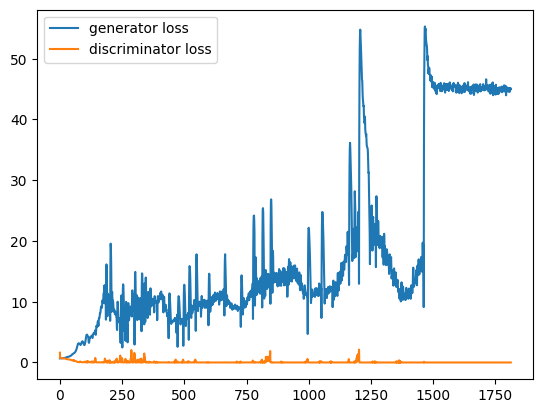

In [24]:
# 1. Plot loss graphs
plt.plot(g_losses, label="generator loss")
plt.plot(d_losses, label="discriminator loss")
plt.legend()

In [27]:
# 2. Visualize synthetic samples
# 2.1 Generate synthetic samples
number_of_samples_to_generate = 50

def generate_n_samples(n_to_generate, generator, prior_generation_function):
    with torch.no_grad():
        # Generate prior
        prior: Tensor = prior_generation_function(n_to_generate, prior_size).to(DEVICE)

        # Generate samples
        generator_output = generator(prior)

    # Return samples
    return generator_output

synthetic_samples = generate_n_samples(number_of_samples_to_generate, generator_instance, generate_2d_normal_prior)\
    .reshape(number_of_samples_to_generate, 28, 28)

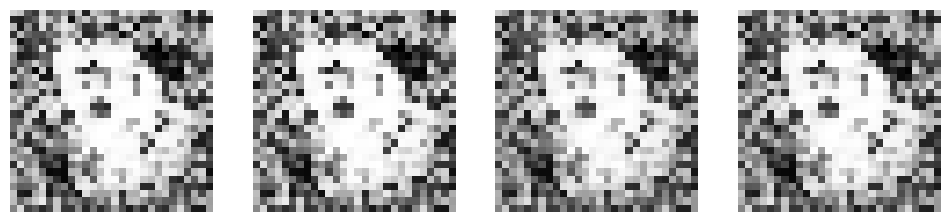

In [28]:
plot_5(synthetic_samples)

## 7. Limitations of GANs

While GANs are powerful tools for generating realistic synthetic data, they do come with their own set of limitations. Understanding these limitations can help in effectively applying GANs and in pursuing future research directions. Here are a few key ones:

1. **Mode Collapse:** This happens when the generator starts producing the same output (or minor variations) over and over again, instead of generating diverse samples. It's a common issue in GAN training due to the dynamic nature of the adversarial process.

2. **Training Stability:** GANs are notoriously hard to train. The simultaneous training of two networks (generator and discriminator) in an adversarial setup leads to a highly dynamic and unstable process. The networks may oscillate, and it might take a while to reach an equilibrium.

3. **Lack of Explicit Control:** In a basic GAN setup, there's no way to control the kind of output the generator produces. It may be possible to guide the generation process by conditioning the generator with additional information, but this requires modifications to the basic GAN architecture.

4. **Evaluation Difficulty:** It's challenging to measure the quality and diversity of the samples generated by GANs. Commonly used metrics, like Inception Score and Frechet Inception Distance, have their own limitations and biases.

## 8. Summary and Conclusion <a class='anchor' id='section8'></a>


In this notebook, we've explored the fascinating world of Generative Adversarial Networks (GANs). We've learned about the theory of GANs, their unique adversarial setup, and how they can generate new, realistic data. We've also implemented a simple GAN using the PyTorch library and trained it on the MNIST dataset.

Here are the key takeaways from our exploration:

1. **GAN Structure:** A GAN consists of two neural networks – a generator and a discriminator – that are trained together. The generator creates synthetic data, and the discriminator evaluates the authenticity of this data.

2. **Training Process:** The training involves an iterative process, alternating between training the generator to produce more realistic data and training the discriminator to better distinguish between real and fake data.

3. **MNIST Dataset:** We used the MNIST dataset for our GAN training. The dataset was preprocessed, including normalization and reshaping of the images, before being used for training.

4. **GAN Limitations:** While GANs are powerful, they have their limitations, including mode collapse, training stability, lack of control over the output, and evaluation difficulty.

Looking ahead, there's still much to explore with GANs. Advanced variations of GANs have been developed to address some of their limitations and to extend their capabilities. These include Conditional GANs, Wasserstein GANs, CycleGANs, and more. These advanced GANs have been used for tasks such as image-to-image translation, super-resolution, and even generating art!

GANs represent a vibrant area of research in AI. We continue to improve their stability, control, and diversity!

## 9. Exercises and Challenges <a class='anchor' id='section9'></a>

To further deepen your understanding of GANs, we recommend the following exercises and challenges. These tasks will allow you to apply what you've learned in this notebook and explore more advanced GAN topics.

1. **Modify the GAN Architecture:** Try modifying the architecture of the generator and discriminator. You could change the number of layers, the number of neurons in each layer, or the types of layers used (e.g., introducing convolutional layers).

2. **Change the Dataset:** Train the GAN on a different dataset. You could use another standard dataset such as CIFAR-10, or you could even try a custom dataset of your own!

3. **Experiment with Different Loss Functions:** Explore different loss functions for training the GAN, such as Wasserstein loss or hinge loss.

4. **Implement a Different Type of GAN:** Try implementing a more advanced type of GAN, such as a Deep Convolutional GAN (DCGAN), Conditional GAN (CGAN), or CycleGAN. These GANs offer additional features and capabilities beyond the basic GAN implemented in this notebook.

5. **GAN Evaluation:** Investigate different ways to evaluate the performance of your GAN. This could involve implementing metrics like the Inception Score or Frechet Inception Distance, or qualitative methods like visual inspection or user studies.

Remember, the best way to learn is by doing. Good luck with your GAN journey!